# Oh hey

This homework is just coding. We will code up $Q$-learning for the frozen lake problem and then see a simple, exact method for doing LQR from data.

In [1]:
import gym
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

%matplotlib inline
env=gym.make('FrozenLake-v0')
env.render()


SFFF
FHFH
FFFH
HFFG


# Question

Use Q-learning to learn a policy for this problem. Simulate $100,000$ episodes. Let $G^i$ be the total reward for episode $i$. 

Make a plot of $\frac{1}{i}\sum_{j=1}^i G^j$ (the running average of the rewards), for $i=1$ to $100,000$. 

As with the other algorithms, getting high rewards may take a lot of fine tuning. Just like last week, you'll probably need to tune the exploration parameter, $\epsilon$. Additionally, you'll need to tune the step size parameter, $\alpha$. Try to get it to learn well, but don't spend forever tuning parameters. Go outside. Treat yourself. 

You will probably need to use a discount factor of $\gamma <1$ to make it work correctly.

In [2]:
# Make your simulation here

1000 0.079 0.0647762981885363 0.5273981902261111
2000 0.135 0.10820499611842178 0.5138348002376256
3000 0.17666666666666667 0.14050232596807963 0.589664311700334
4000 0.192 0.1525069715866381 0.5133156628358805
5000 0.2036 0.16068269667256704 0.5052031405154198
6000 0.21333333333333335 0.16767813332604134 0.534394771327501
7000 0.22157142857142856 0.1731154669897897 0.5284606735688585
8000 0.230125 0.1795699070524422 0.5502553117726452
9000 0.23466666666666666 0.18293192687718662 0.5453340650429828
10000 0.2423 0.18849751098612336 0.5658922623578153
11000 0.24609090909090908 0.19134500085140632 0.5665631430763471
12000 0.25125 0.19506834857683641 0.5520943047310861
13000 0.2562307692307692 0.1987156549344924 0.554930898393573
14000 0.2607857142857143 0.2021219935539164 0.5517004605642439
15000 0.2644 0.20466175735164405 0.5527002428384886
16000 0.2683125 0.20777298635351024 0.5607804958863362
17000 0.27105882352941174 0.20966610073937056 0.5412291231115451
18000 0.27355555555555555 0.2

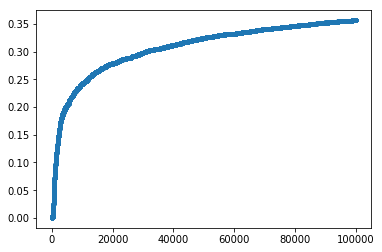

In [3]:
# Solution

import finiteStateAgents as fs


NumEpisodes = 100000
gamma = .99
agent = fs.qAgent(env,epsilon=1.,gamma = gamma,alpha=.01)
beta = .2

R_tot = []
Ret_tot = []

posCount = 0
posHappened = False

ep = 0
#while posCount < 100:
for ep in range(NumEpisodes):
    s = env.reset()
    epsilon = (1/(1+ep))**(beta)
    ep += 1
    agent.epsilon = epsilon
    R = []
    done = False
    posHappened = False
    while not done:
        a = agent.action(s)
        
        s_next, reward, done, info = env.step(a)
        agent.update(s,a,reward,s_next,done,info)
        s = s_next
        R.append(reward)
        if done:
            Return = fs.calculateReturns(R,gamma)
            Ret_tot.append(Return[0])
            R_tot.append(np.sum(R))
            
            
            
            break
            
    if ((ep+1) % 1000) == 0:
        print(ep+1,np.sum(R_tot)/(ep+1),np.sum(Ret_tot)/(ep+1),np.max(agent.q[0]))
            
            
            
plt.plot(np.cumsum(R_tot)/np.arange(1,NumEpisodes+1),'.')

# An exact optimal gain from measurements

In class on Friday, Oct. 25, we discussed a paper by Bradtke, Ydstie, and Barto. It is posted on the canvas for reference.

This work assumes that the initial controller is stabilizing. This is a major limitation of this and many works on reinforcement learning, especially for continuous systems, and LQR in particular.

In this problem, we will give a very simple method to compute a stabilizing controller from trajectory data. 

We consider a problem of the form:

\begin{align*}
& \min && \sum_{t=0}^{\infty} (x_t^\top Q x_t + u_t^\top R u_t) dt \\
& \textrm{subject to} && x_{t+1} = Ax_t + Bu_t,
\end{align*}
where $(A,B,Q,R)$ are unknown matrices. Assume that $x_t \in \mathbb{R}^n$ and $u_t \in \mathbb{R}^p$.

We assume that we can we can observe the state and the cost, put in arbitrary inputs, and restart the system if needed. (This is important for unstable systems, which could grow too large and cause numerical problems.)

The procedure works as follows:

* Generate $N=(n+p)(n+p+1)$ samples $(x_i,u_i,c_i,x_i^+)$ for $i=0,\ldots,N-1$, where $x_i^+ = A x_i + B u_i$ and $c_i = x_i^\top Q x_i + u_i^\top R u_i$. A reasonable procedure for doing this is as follows:
    * Fix an upper bound, $M$, on the size of $\|x\|$. 
    * Generate $x_0$ randomly and ensure that $\|x_i\| \le M$.
    * For $i \ge 0$ assume that the current state $x_i$ with $\|x_i\|\le M$ has been generated already.
        * Generate $u_i$ randomly and apply it to the system.
        * Measure the next state, $x_i^+$ and cost, $c_i$.
        * If $\|x_i^+\| \le M$, set $x_{i+1} = x_i^+$. Otherwise, set $x_{i+1}$ randomly and ensure that $\|x_i\|\le M$. 
* Compute $A$ and $B$ via least-squares, based on the system of equations $x_i^+ = Ax_i + Bu_i$ for $i=0,\ldots, N-1$.
* Compute $Q$ and $R$ vial least-squares, based on the system of equations $c_i = x_i^\top Q x_i + u_i^\top R u_i$. (Using the reshaping trick from the paper is useful for this.)
* Compute the optimal gain via the discrete-time algebraic Riccati equation.
        
Some notes:
* The calculations of $(A,B,Q,R)$ are exact with high probability. 
* There are many ways to generate samples that would work besides the one chosen. 
* Enforcing the bound on $\|x\|$ is just for numerical stability. 
* The number of samples is chosen so that all of the required matrices have full rank with high probability. Specifically, $N$ is twice the dimension of the reshaped vector used to compute $Q$ and $R$. (More compact parameterizations that exploit the fact that there are no cross terms between $x$ and $u$ could also be used. This would then require fewer samples.)
* A more complex "model-free" procedure is decribed after the problem. (You do not need to solve it.)




In [8]:
# Use this to generate random systems for testing
import numpy.random as rnd
import scipy.stats as st

def randomSystem():

    n = rnd.randint(1,10)
    p = rnd.randint(1,10)

    A = rnd.randn(n,n)
    B = rnd.randn(n,p)

    Q = st.wishart.rvs(n+1,np.eye(n)).reshape((n,n))
    R = st.wishart.rvs(p+1,np.eye(p)).reshape((p,p))
    
    return A,B,Q,R

# Question

Code up the solution described above. Test it on several randomly generated systems. Print out $\|K - K^*\|$, where $K$ is the solution that you estimated, and $K^*$ is the true optimal solution.

In [13]:
# Make your solution here

In [25]:
# Solution



#######  Helper Code #######
import scipy.linalg as la
def trilStack(M):
    n = len(M)
    v = []
    for i in range(n):
        v.append(M[i:,i])
    return np.hstack(v)

def trilUnstack(v):
    d = len(v)
    n = int((np.sqrt(1+8*d)-1)/2)
    M = np.zeros((n,n))
    j = 0
    for i in range(n):
        M[i:,i] = v[j:j+n-i]
        j = j+n-i
    return M

def symFromTrilStack(v):
    L = trilUnstack(v)
    D = np.diag(np.diag(L))
    return L + L.T - D

def quadraticMonomials(z):
    M = np.outer(z,z)
    M_L = np.tril(M,-1)
    M_D = np.diag(np.diag(M))
    return trilStack(2*M_L + M_D)

def buildPhi(X,U,X_next,K,gamma):
    Horizon = len(U)
    Phi = []
    for x,u,x_next in zip(X,U,X_next):
        z = np.hstack([x,u])
        z_next = np.hstack([x_next,K@x_next])
        # Accounting for noise requires extra parameter
        psi = np.hstack(quadraticMonomials(z))
        psi_next = np.hstack(quadraticMonomials(z_next))
        phi = psi - gamma * psi_next
        Phi.append(phi)
    return np.array(Phi)
    
    
    
def getVandQmatrices(X,U,X_next,c,K,gamma):
    F = np.vstack([np.eye(n),K])
    Phi = buildPhi(X,U,X_next,K,gamma)
    theta = la.lstsq(Phi,c)[0]
    # The first entry of theta is the noise variance
    Q_mat = symFromTrilStack(theta)
    P = F.T @ Q_mat @ F
    return P,Q_mat
    
def increaseGamma(X,U,X_next,c,K,gamma):
    LB = gamma 
    UB = 1.
    
    p,n = K.shape
    
    
    
    minEig = -np.inf
    while minEig < 0:
        gamma = .5 * (LB + UB)
        P,Q_mat = getVandQmatrices(X,U,X_next,c,K,gamma)
        minEig = la.eigvalsh(P,eigvals=[0,0])[0]
        if minEig < 0:
            UB = gamma
    return gamma, Q_mat, P
    
def genX(n,b):
    r = rnd.rand() * b
    x = rnd.randn(n)
    return r * x / la.norm(x)


##### Main Solution #####

NumTests = 10

for test in range(NumTests):
    A,B,Q,R = randomSystem()
    n,p = B.shape


    # The true solution for validation purposes
    P_opt = la.solve_discrete_are(A,B,Q,R)
    K_opt = -la.solve(R+B.T@P_opt@B,B.T@P_opt@A)

    x_bound = 100
    x = genX(n,x_bound)

    Horizon = (n+p)*(n+p+1)
    K = np.zeros((p,n))
    gamma = 0.




    X = []
    U = []
    X_next = []
    c = []
    # Simulate the system
    for t in range(Horizon):
        u = K@x + .1 * rnd.randn(p)
        x_next = A@x + B @ u 
        c.append(x@Q@x + u@R@u)
        X.append(x)
        U.append(u)
        X_next.append(x_next)
        if la.norm(x_next) <= x_bound:
            x = x_next
        else:
            x = genX(n,x_bound)
        
    c = np.array(c)
    P,Q_mat = getVandQmatrices(X,U,X_next,c,K,gamma)

    
    Q_est = Q_mat[:n,:n]
    R_est = Q_mat[n:,n:]
    
    X = np.array(X)
    U = np.array(U)
    X_next = np.array(X_next)
    
    Z = np.hstack([X,U])
    AB = la.lstsq(Z,X_next)[0].T
    A_est = AB[:,:n]
    B_est = AB[:,n:]
    
    S_est = la.solve_discrete_are(A_est,B_est,Q_est,R_est)
    K_est = -la.solve(R_est + B_est.T @ S_est @ B_est,B_est.T @S_est @ A)

    print('Test',test+1,', ||K-K*||:',la.norm(K_opt-K_est))
    
    

Test 1 , ||K-K*||: 1.0984554003233293e-11
Test 2 , ||K-K*||: 1.7577971189620997e-09
Test 3 , ||K-K*||: 4.3427359089326685e-11
Test 4 , ||K-K*||: 1.0072441504845038e-10
Test 5 , ||K-K*||: 4.2012751813804464e-12
Test 6 , ||K-K*||: 1.0630482121680235e-10
Test 7 , ||K-K*||: 1.4359986197226938e-10
Test 8 , ||K-K*||: 3.654789351877043e-11
Test 9 , ||K-K*||: 5.987631465078131e-12
Test 10 , ||K-K*||: 1.3094765533660801e-10


# An alternative model free procedure

Here we will just demonstrate an alternative "model-free" procedure (which does not compute $(A,B,Q,R)$). You don't need to solve anything here, but examining this code could be helpful for answering the question above.

Say that $Q$ and $R$ are both positive definite. Then if the system is stabilizable, it computes a sequence of gains $K_i$  with the following properties:

* $K_i$ is a stabilizing controller for all sufficiently large $i$.
* The algorithm provides a certificate of stability  once a stabilizing controller is found.
* $K_i$ converges to the optimum gain geometrically. 
    
    
The method works as follows:
* Start with $K_i=0$ and discount factor $\gamma_i = 0$.
* For each $i\ge 0$ do the following.
    - Generate $N$ samples $(x_j,u_j,c_j,x_j^+)$ as described above. (Any $u_j$ sequence with sufficient noise injection for invertibility will work.)
    - Solve for the action-value function, $Q_{i}(x,u)$ by least-squares, based on the system of equations $c_j = Q_{i}(x_j,u_j) - \gamma_i Q_{i}(x_j^+,K_i x_j^+)$. 
    - Compute $P_i$ such that $x^\top P_i x = Q_i(x,K_i x)$. This is the matrix corresponding to the value function.
    - Let $\gamma_{i+1} > \gamma_i$  be chosen as follows:
        - Let $\hat Q_i$ be the action-value function computed from the equations $c_j = \hat Q_{i}(x_j,u_j) - \gamma_{i+1} \hat Q_{i}(x_j^+,K_i x_j^+)$
        - Let $\hat P_i$ be the corresponding value function matrix
        - Use bisection to find the largest value of $\gamma_{i+1}$ so that
            - $\gamma_{i+1} \le 1$
            - $\hat P_i$ is positive definite
            - $\|P_i - \hat P_i \|\le 1$. (For some matrix norm, e.g. Frobenius or induced 2 norm.)
           
    - Let $K_{i+1}$ be the minimizing gain: $\min_u \hat Q_i(x,u) = \hat Q_i(x,K_{i+1})$
    
    
With this description, the properties of the algorithm can be described more precisely.
* $\gamma_i$ is monotonically increasing.
* For all $i$, $K_i$ stabilizes the system $(\sqrt{\gamma_i} A,\sqrt{\gamma_i}B)$.
* If $\gamma_i = 1$, then $K_i$ is stabilizing. Furthermore, $\gamma_j=1$ and $K_j$ is stabilizing for all $j\ge i$.
* If the system is stabilizable, then:
    - $\gamma_i=1$ after finitely many steps
    - Once $\gamma_i=1$, the steps become equivalent to policy iteration, and thus converge to the optimal gain.
* If the system is not stabilizable,then $\lim_{i\to\infty} \gamma_i =\hat\gamma$ such that $(\sqrt{\hat \gamma} A,\sqrt{\hat \gamma }B)$ is not stabilizable. 

In [28]:
#######  Helper Code #######
import scipy.linalg as la
def trilStack(M):
    n = len(M)
    v = []
    for i in range(n):
        v.append(M[i:,i])
    return np.hstack(v)

def trilUnstack(v):
    d = len(v)
    n = int((np.sqrt(1+8*d)-1)/2)
    M = np.zeros((n,n))
    j = 0
    for i in range(n):
        M[i:,i] = v[j:j+n-i]
        j = j+n-i
    return M

def symFromTrilStack(v):
    L = trilUnstack(v)
    D = np.diag(np.diag(L))
    return L + L.T - D

def quadraticMonomials(z):
    M = np.outer(z,z)
    M_L = np.tril(M,-1)
    M_D = np.diag(np.diag(M))
    return trilStack(2*M_L + M_D)

def buildPhi(X,U,X_next,K,gamma):
    Horizon = len(U)
    Phi = []
    for x,u,x_next in zip(X,U,X_next):
        z = np.hstack([x,u])
        z_next = np.hstack([x_next,K@x_next])
        # Accounting for noise requires extra parameter
        psi = np.hstack(quadraticMonomials(z))
        psi_next = np.hstack(quadraticMonomials(z_next))
        phi = psi - gamma * psi_next
        Phi.append(phi)
    return np.array(Phi)
    
    
    
def getVandQmatrices(X,U,X_next,c,K,gamma):
    F = np.vstack([np.eye(n),K])
    Phi = buildPhi(X,U,X_next,K,gamma)
    theta = la.lstsq(Phi,c)[0]
    # The first entry of theta is the noise variance
    Q_mat = symFromTrilStack(theta)
    P = F.T @ Q_mat @ F
    return P,Q_mat
    
def increaseGamma(X,U,X_next,c,K,gamma):
    LB = gamma 
    UB = 1.
    
    p,n = K.shape
    
    
    
    minEig = -np.inf
    while minEig < 0:
        gamma = .5 * (LB + UB)
        P,Q_mat = getVandQmatrices(X,U,X_next,c,K,gamma)
        minEig = la.eigvalsh(P,eigvals=[0,0])[0]
        if minEig < 0:
            UB = gamma
    return gamma, Q_mat, P
    
def genX(n,b):
    r = rnd.rand() * b
    x = rnd.randn(n)
    return r * x / la.norm(x)

#### Main Code ##### 

NumEpisodes = 10
x_bound = 100
x = genX(n,x_bound)

Horizon = (p+n)*(p+n+1)
K = np.zeros((p,n))
gamma = 0.


P_opt = la.solve_discrete_are(A,B,Q,R)
K_opt = -la.solve(R+B.T@P_opt@B,B.T@P_opt@A)

K_err = 10

ep =0
while K_err > 1e-6 :
    ep += 1
    X = []
    U = []
    X_next = []
    c = []
    # Simulate the system
    for t in range(Horizon):
        u = K@x + .1 * rnd.randn(p)
        x_next = A@x + B @ u 
        c.append(x@Q@x + u@R@u)
        X.append(x)
        U.append(u)
        X_next.append(x_next)
        if la.norm(x_next) <= x_bound:
            x = x_next
        else:
            x = genX(n,x_bound)
        
    c = np.array(c)
    
    eigMax = np.max(np.abs(la.eigvals(A+B@K)))
    K_err = la.norm(K-K_opt)
    print('Episode: ',ep,', ||K-K*||:',K_err, ', rho(A+BK):', eigMax)
    gamma,Q_mat, P = increaseGamma(X,U,X_next,c,K,gamma)
    # improve K
    Omega = Q_mat[n:,n:]
    Psi = Q_mat[n:,:n]
    K = -la.solve(Omega,Psi)
    

Episode:  1 , ||K-K*||: 2.8293011547624474 , rho(A+BK): 2.5469778335828552
Episode:  2 , ||K-K*||: 0.8213846938625275 , rho(A+BK): 0.9004890773923384
Episode:  3 , ||K-K*||: 0.13174047620987492 , rho(A+BK): 0.14869738602772134
Episode:  4 , ||K-K*||: 0.1124223562259624 , rho(A+BK): 0.17424090016702282
Episode:  5 , ||K-K*||: 0.053052738911372285 , rho(A+BK): 0.15690529074164888
Episode:  6 , ||K-K*||: 0.0255830186314108 , rho(A+BK): 0.14895854906002565
Episode:  7 , ||K-K*||: 0.012567647598778098 , rho(A+BK): 0.14523986608874528
Episode:  8 , ||K-K*||: 0.0062293151251444434 , rho(A+BK): 0.14344099687498893
Episode:  9 , ||K-K*||: 0.0031012087477023296 , rho(A+BK): 0.14255633727269618
Episode:  10 , ||K-K*||: 0.0015472642263009673 , rho(A+BK): 0.1421176563060563
Episode:  11 , ||K-K*||: 0.0007727998183582858 , rho(A+BK): 0.14189922231492308
Episode:  12 , ||K-K*||: 0.0003861921773153312 , rho(A+BK): 0.14179023122209977
Episode:  13 , ||K-K*||: 0.00019304419837337102 , rho(A+BK): 0.14173